# Entraînement transfer learning de modèles pré-entraînés
Ce notebook présente :
- Chargement des données prétraitées
- Définition d’un modèle pré-entraîné
- Entraînement et évaluation
- Sauvegarde du meilleur modèle

## Imports, config & seeds

In [2]:
import os, random, subprocess
from datetime import date

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from src.config_utils import load_config
from src.data_loader import load_from_splits
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import EfficientNetB0  # ou autre

import shutil

In [3]:
# Charger la config “transfer”
cfg = load_config('../configs/config_transfer.yaml')

# Fixer les seeds
random.seed(cfg['seed'])
np.random.seed(cfg['seed'])
tf.random.set_seed(cfg['seed'])

# Paramètres depuis la config
DATA_PROCESSED = cfg['data']['processed_dir']
IMG_SIZE       = tuple(cfg['preprocessing']['target_size'])
BATCH_SIZE     = cfg['training']['batch_size']
EPOCHS         = cfg['training']['epochs']
LR             = float(cfg['training']['learning_rate'])
EARLYSTOP_CFG  = cfg['training']['early_stopping']
MODEL_TYPE     = cfg['training']['model_type']

## Génération du run_id & préparation des dossiers

In [4]:
# run_id = date + git hash
today = date.today().isoformat()
commit = subprocess.check_output(['git','rev-parse','--short','HEAD']).decode().strip()
run_id = f"{today}_{commit}"

# dossiers de sortie
CKPT_DIR = os.path.join('..','outputs','checkpoints', 'all', 'transfer')
CFG_OUT  = os.path.join('..','outputs','configs','all')
FIG_OUT  = os.path.join('..','outputs','figures', 'all', 'transfer')
LOG_OUT  = os.path.join('..','outputs','logs', 'all','transfer')

for d in (CKPT_DIR, CFG_OUT, FIG_OUT, LOG_OUT):
    os.makedirs(d, exist_ok=True)

print("Run ID :", run_id)

Run ID : 2025-07-04_7c09ce4


## Chargement des splits

In [5]:
train_ds, class_indices = load_from_splits('../splits/train.txt', BATCH_SIZE, IMG_SIZE)
val_ds,   _             = load_from_splits('../splits/val.txt',   BATCH_SIZE, IMG_SIZE)
num_classes = len(class_indices)
print("Classes :", class_indices)

Classes : {'non_toxic': 0, 'toxic': 1}


## Construction du modèle pré-entraîné

In [6]:
# Choix du backbone
if MODEL_TYPE == 'efficientnetb0':
    base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=IMG_SIZE+(3,))
elif MODEL_TYPE == 'mobilenetv2':
    from tensorflow.keras.applications import MobileNetV2
    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=IMG_SIZE+(3,))
else:
    raise ValueError(f"Modèle inconnu : {MODEL_TYPE}")

base.trainable = False  # geler les couches

# Ajouter la « tête » de classification
inputs = tf.keras.Input(shape=IMG_SIZE+(3,))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = models.Model(inputs, outputs, name=f"transfer_{MODEL_TYPE}")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "transfer_efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,052,133 (15.46 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Callbacks & Entraînement

In [7]:
# Checkpoint
ckpt_path = os.path.join(CKPT_DIR, f"{run_id}_transfer_{MODEL_TYPE}.keras")
checkpoint_cb = callbacks.ModelCheckpoint(
    ckpt_path, save_best_only=True, monitor="val_accuracy", mode="max"
)
earlystop_cb = callbacks.EarlyStopping(
    **EARLYSTOP_CFG, restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 217ms/step - accuracy: 0.4777 - loss: 0.7274 - val_accuracy: 0.6364 - val_loss: 0.6731
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.5709 - loss: 0.6954 - val_accuracy: 0.6364 - val_loss: 0.6630
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.5370 - loss: 0.7159 - val_accuracy: 0.6364 - val_loss: 0.6629
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.5269 - loss: 0.7149 - val_accuracy: 0.6364 - val_loss: 0.6637
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.5368 - loss: 0.7192 - val_accuracy: 0.6364 - val_loss: 0.6614
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.5058 - loss: 0.7209 - val_accuracy: 0.6364 - val_loss: 0.6608


## Sauvegarde de la config, figures & logs

Courbes : ../outputs/figures/all/transfer/2025-07-04_7c09ce4_curves_transfer.png
Metrics : ../outputs/logs/all/transfer/2025-07-04_7c09ce4_metrics_transfer.txt


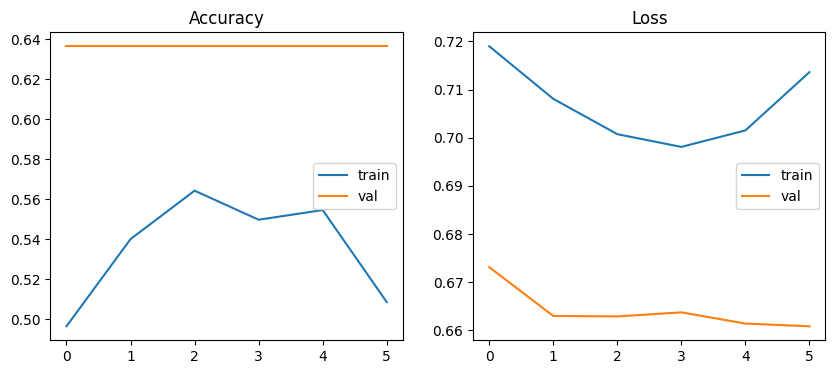

In [8]:
# config
dst_cfg = os.path.join(CFG_OUT, f"{run_id}_config_transfer.yaml")
shutil.copy('../configs/config_transfer.yaml', dst_cfg)

# courbes
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend(); plt.title("Accuracy")
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend(); plt.title("Loss")
fig_path = os.path.join(FIG_OUT, f"{run_id}_curves_transfer.png")
plt.savefig(fig_path)
print("Courbes :", fig_path)

# metrics
metrics_path = os.path.join(LOG_OUT, f"{run_id}_metrics_transfer.txt")
with open(metrics_path, 'w') as f:
    for k,v in history.history.items():
        f.write(f"{k}: {v}\n")
print("Metrics :", metrics_path)

plt.show()

## Évaluation & prédiction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


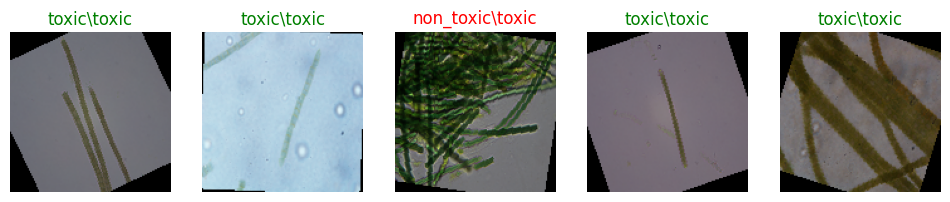

In [19]:
# Exemple rapide sur 5 images du val set
import numpy as np
import matplotlib.pyplot as plt

for images, labels in val_ds.take(1):
    preds = model.predict(images)
    plt.figure(figsize=(12,4))
    for i in range(5):
        plt.subplot(1,5,i+1)
        plt.imshow(images[i])
        true = list(class_indices.keys())[labels.numpy()[i]]
        pred = list(class_indices.keys())[np.argmax(preds[i])]
        color = 'green' if true==pred else 'red'
        plt.title(f"{true}\\{pred}", color=color)
        plt.axis('off')
    plt.show()
